# Lab3

## Import

In [1]:
import numpy as np, pandas as pd, random
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

SEED = 42
random.seed(SEED)

df = pd.read_csv("chinese_mnist.csv")
df["filename"] = df.apply(lambda r: f"data/input_{r.suite_id}_{r.sample_id}_{r.code}.jpg", axis=1)
classes = sorted(df.code.unique())
df.head()

,suite_id,sample_id,code,value,character,filename
0,1,1,10,9,九,data/input_1_1_10.jpg
1,1,10,10,9,九,data/input_1_10_10.jpg
2,1,2,10,9,九,data/input_1_2_10.jpg
3,1,3,10,9,九,data/input_1_3_10.jpg
4,1,4,10,9,九,data/input_1_4_10.jpg


### Step 3

In [2]:
def stratified_indices(n_train, n_test):
    per_train, per_test = n_train // 15, n_test // 15
    extra_tr, extra_te = n_train - per_train*15, n_test - per_test*15
    tr_idx, te_idx = [], []
    for c in classes:
        pool = df.index[df.code == c].tolist()
        random.shuffle(pool)
        k_tr = per_train + (extra_tr > 0)
        k_te = per_test + (extra_te > 0)
        extra_tr -= extra_tr > 0
        extra_te -= extra_te > 0
        tr_idx += pool[:k_tr]
        te_idx += pool[k_tr:k_tr+k_te]
    return tr_idx, te_idx

### Step 4

In [3]:
def load_flat(indices):
    X = np.empty((len(indices), 64*64), np.float32)
    y = np.empty(len(indices), np.int16)
    for i, idx in enumerate(indices):
        row = df.loc[idx]
        img = Image.open(row.filename).convert("L")
        X[i] = np.asarray(img, np.float32).flatten() / 255.0
        y[i] = row.code
    return X, y


In [4]:
train5_idx, test_idx = stratified_indices(5000, 1000)
X_train5, y_train5 = load_flat(train5_idx)
X_test,   y_test   = load_flat(test_idx)

train10_idx, _ = stratified_indices(10000, 1000)
X_train10, y_train10 = load_flat(train10_idx)

### Step 5

In [5]:
dic = {'KNN': {'classifier':KNeighborsClassifier(n_neighbors=3)},
       'DT' : {'classifier':DecisionTreeClassifier(random_state=SEED)},
       'SGD': {'classifier':SGDClassifier(max_iter=250, random_state=SEED)}}
dic10 = {'KNN': {'classifier':KNeighborsClassifier(n_neighbors=3)},
       'DT' : {'classifier':DecisionTreeClassifier(random_state=SEED)},
       'SGD': {'classifier':SGDClassifier(max_iter=250, random_state=SEED)}}

### Step 6

In [6]:
for i in dic.keys():
    dic[i]['classifier'].fit(X_train5, y_train5)

for i in dic10.keys():
    dic10[i]['classifier'].fit(X_train10, y_train10)

### Step 7

In [7]:
for i in dic.keys():
    dic[i]['pred'] = dic[i]['classifier'].predict(X_test)

for i in dic10.keys():
    dic10[i]['pred'] = dic10[i]['classifier'].predict(X_test)

### Step 8

In [8]:
ans = {}
ans10 = {}

for i in dic.keys():
    y_p = dic[i]['pred']
    ans[i] = (accuracy_score(y_test, y_p),
                precision_score(y_test, y_p, average="macro", zero_division=0),
                recall_score(y_test, y_p, average="macro", zero_division=0),
                f1_score(y_test, y_p, average="macro", zero_division=0))

for i in dic10.keys():
    y_p = dic10[i]['pred']
    ans10[i] = (accuracy_score(y_test, y_p),
                precision_score(y_test, y_p, average="macro", zero_division=0),
                recall_score(y_test, y_p, average="macro", zero_division=0),
                f1_score(y_test, y_p, average="macro", zero_division=0))

#### classification metrics(5000)

In [9]:
pd.DataFrame(ans, index=["Accuracy","Precision","Recall","F1"])

,KNN,DT,SGD
Accuracy,0.345000,0.278000,0.370000
Precision,0.541216,0.267765,0.376238
Recall,0.344550,0.277733,0.369652
F1,0.347494,0.270672,0.370646


#### classification metrics(10000)

In [10]:
pd.DataFrame(ans10, index=["Accuracy","Precision","Recall","F1"])

,KNN,DT,SGD
Accuracy,0.551000,0.778000,0.605000
Precision,0.736310,0.779714,0.608984
Recall,0.550641,0.777959,0.604824
F1,0.578246,0.778108,0.596375


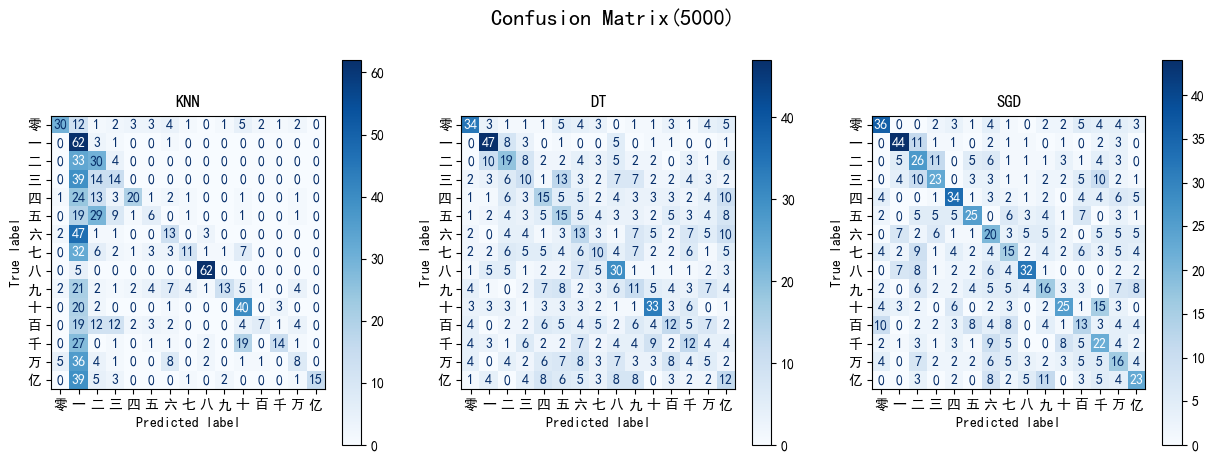

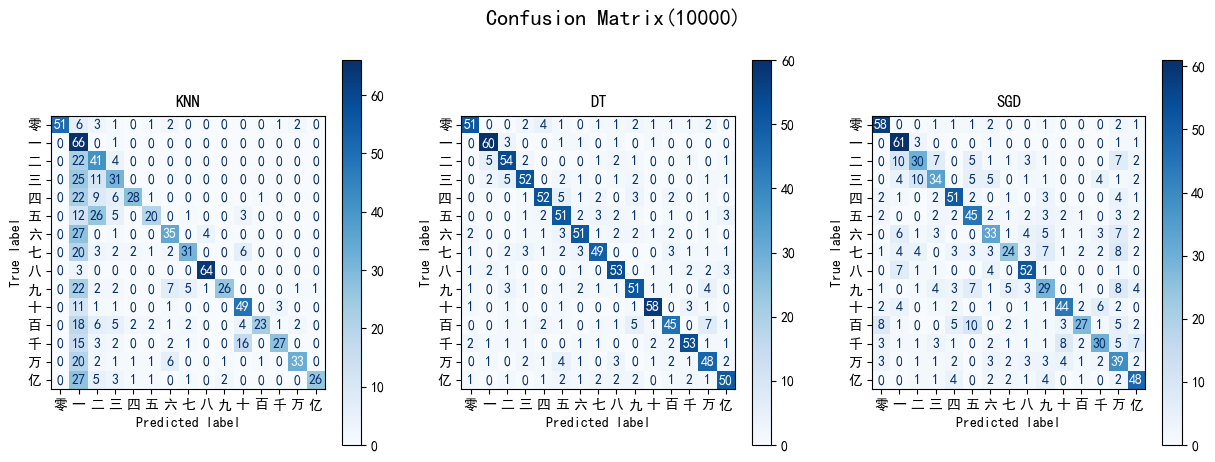

In [11]:
characters = [df[df.code == c].character.iloc[0] for c in classes]
plt.rcParams['font.family'] = 'SimHei'

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, i in zip(axes, dic.keys()):
    disp = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_test, dic[i]['pred'], labels=classes),
        display_labels=characters)
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(i)
plt.suptitle("Confusion Matrix(5000)", fontsize=16)
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, i in zip(axes, dic10.keys()):
    disp = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_test, dic10[i]['pred'], labels=classes),
        display_labels=characters)
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(i)
plt.suptitle("Confusion Matrix(10000)", fontsize=16)
plt.show()

- The impact of doubling the sample size
    - The accuracy of both DT and SGD has significantly improved by +279% and +163% respectively, and Precision/Recall/F1 have all been comprehensively enhanced.
    - KNN still maintains a relatively high Precision, but the overall F1 and Accuracy of SGD are slightly better.